In [2]:
import dtt2hdf
import matplotlib.pyplot as plt
import numpy as np
items = dtt2hdf.read_diaggui('./data/SRM_TML_200722.xml')


In [18]:
items.keys()

dict_keys(['references', 'results'])

In [13]:
type(items)

declarative.bunch.bunch.Bunch

In [43]:
items.results.PSD['K1:VIS-SRM_TM_TEST_L_EXC'].PSD[0]

array([123.427246, 293.78098 , 370.33636 , ...,  85.48593 , 134.84073 ,
       129.88141 ], dtype=float32)

In [182]:
f=items.results.CSD['K1:VIS-SRM_TM_TEST_L_EXC'].FHz
mask = 0.01<f
mask2 = f<10
mask=mask*mask2
# mask2 = f<10
f=f[mask]
L2P_CSD = items.results.CSD['K1:VIS-SRM_TM_TEST_L_EXC'].CSD[10]
L_exc_PSD = items.results.PSD['K1:VIS-SRM_TM_TEST_L_EXC'].PSD[0]
L2P = L2P_CSD/L_exc_PSD**2
L2P=L2P[mask]

In [116]:
mask2

array([ True,  True,  True, ..., False, False, False])

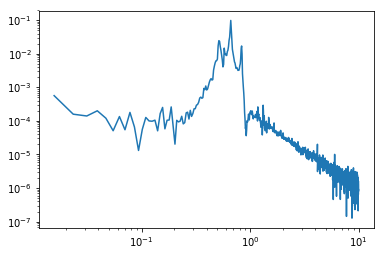

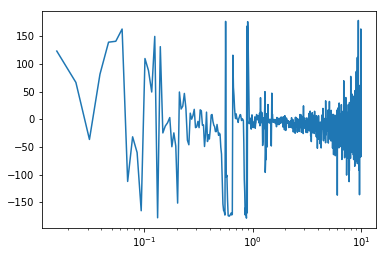

In [165]:
plt.loglog(f, abs(L2P))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(L2P)*180/np.pi))
# plt.xlim(0.1,10)
# plt.ylim()

In [34]:
from control import *

In [66]:
def sso(fn, Q, unit = 'Hz'):
    if unit == 'Hz':
        fn = 2*np.pi*fn
    return(tf([fn**2],[1, fn/Q, fn**2]))

In [277]:
L2P_model = -1e-4*sso(0.52,100)*sso(0.57,100)*sso(0.65,1000)*sso(0.8,1000)/sso(0.9,1000)/sso(0.3,5)/sso(0.55,100)

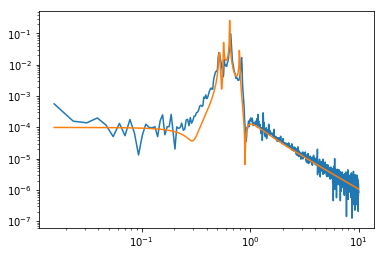

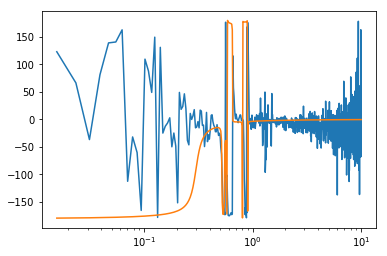

In [278]:
plt.loglog(f, abs(L2P))
plt.loglog(f, abs(L2P_model.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(L2P)*180/np.pi))
plt.semilogx(f, np.angle(L2P_model.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
# plt.xlim(0.1,10)

In [136]:
def cost(args, reference_model, f, data, weight=None):
    if weight is None:
        weight = np.ones_like(f)
    model_num = args[0:len(reference_model.num[0][0])]
    model_den = args[len(reference_model.num[0][0]):len(args)]
    model = tf(model_num, model_den)
    residue = sum(abs((model.horner(2*np.pi*f*1j)[0][0]-data)/abs(data))*weight)
    return(residue)

In [285]:
def cost_stable(args, f, data, weight):
    k=args[0]
    p1=args[1]
    p2=args[2]
    p3=args[3]
    p4=args[4]
    z5=args[5]
    z6=args[6]
    z7=args[7]
    q1=args[8]
    q2=args[9]
    q3=args[10]
    q4=args[11]
    q5=args[12]
    q6=args[13]
    q7=args[14]
    model = k*sso(p1,q1)*sso(p2,q2)*sso(p3,q3)*sso(p4,q4)/sso(z5,q5)/sso(z6,q6)/sso(z7,q7)
    residue = sum(abs((model.horner(2*np.pi*f*1j)[0][0]-data)/abs(data))*weight)
    return(residue)

In [137]:
cost(x0, L2P_model, f, L2P)

671.4854017059074

In [248]:
from scipy.optimize import minimize, differential_evolution

In [123]:
x0=list(L2P_model.num[0][0])+list(L2P_model.den[0][0])

In [187]:
weight = np.ones_like(f)
for i in range(len(weight)):
    if f[i]<0.1 or f[i]>2:
        weight[i]=0
res = minimize(cost, args=(L2P_model, f, L2P, weight), x0 = x0, method='Nelder-Mead', 
               options= {'disp':True, 'maxiter': 100000, 'maxfev': 100000})

Optimization terminated successfully.
         Current function value: 90.605384
         Iterations: 5081
         Function evaluations: 7073


In [283]:
# L2P_model = -1e-4*sso(0.52,100)*sso(0.57,100)*sso(0.65,1000)*sso(0.8,1000)/sso(0.9,1000)/sso(0.3,5)/sso(0.55,100)
x0=[-1e-4]
x0_p=[0.52, 0.57, 0.65, 0.8]
x0_z=[0.3, 0.55, 0.9]
x0_q=[100, 100, 1000, 1000, 5, 100, 1000]
x0+=x0_p
x0+=x0_z
x0+=x0_q
len(x0)

15

In [286]:
weight = np.ones_like(f)
for i in range(len(weight)):
    if f[i]<0.1 or f[i]>2:
        weight[i]=0
for i in range(len(weight)):
    if f[i]>0.5 and f[i]<0.8:
        weight[i]=10
res = minimize(cost_stable, args=(f, L2P, weight), x0 = x0, method='Nelder-Mead', 
               options= {'disp':True, 'maxiter': 100000, 'maxfev': 100000})
# res = differential_evolution(cost_stable, args = (f, L2P, weight),
#                              bounds = [(-1e20, 1e20), 
#                                        (0.1, 1), (0.1, 1), (0.1, 1), 
#                                        (0.1, 1), (0.1, 1), 
#                                        (0.5, 1000), (0.5, 1000), (0.5, 1000),
#                                       (0.5, 1000), (0.5, 1000)])

In [288]:
args=res.x
k=args[0]
p1=args[1]
p2=args[2]
p3=args[3]
p4=args[4]
z5=args[5]
z6=args[6]
z7=args[7]
q1=args[8]
q2=args[9]
q3=args[10]
q4=args[11]
q5=args[12]
q6=args[13]
q7=args[14]
L2P_fit = k*sso(p1,q1)*sso(p2,q2)*sso(p3,q3)*sso(p4,q4)/sso(z5,q5)/sso(z6,q6)/sso(z7,q7)

In [241]:
x0

[-0.0001, 0.52, 0.65, 0.8, 0.3, 0.9, 100, 5, 1000, 1000, 1000]

In [250]:
res

     fun: 237.40509300993358
     jac: array([-6.10459665e+00,  1.23051791e-01,  8.70443273e-02,  1.95939265e-02,
       -2.18393723e+01,  6.28119778e-03, -2.95585778e-04, -1.11128884e-03,
       -2.33058017e-04, -5.68434189e-06,  2.27373675e-05])
 message: 'Optimization terminated successfully.'
    nfev: 17217
     nit: 92
 success: True
       x: array([4.93301292e-05, 7.40790923e-01, 4.79231452e-01, 7.80806839e-01,
       1.00000000e+00, 7.74570796e-01, 8.66348016e+02, 2.11921813e+02,
       8.87269441e+02, 8.71843084e+02, 4.93921940e+02])

In [251]:
args=res.x
fit_num = args[0:len(L2P_model.num[0][0])]
fit_den = args[len(L2P_model.num[0][0]):len(args)]
L2P_fit = tf(fit_num, fit_den)
L2P_fit
args

array([4.93301292e-05, 7.40790923e-01, 4.79231452e-01, 7.80806839e-01,
       1.00000000e+00, 7.74570796e-01, 8.66348016e+02, 2.11921813e+02,
       8.87269441e+02, 8.71843084e+02, 4.93921940e+02])

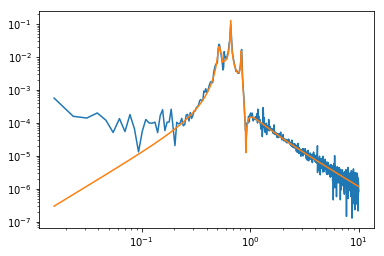

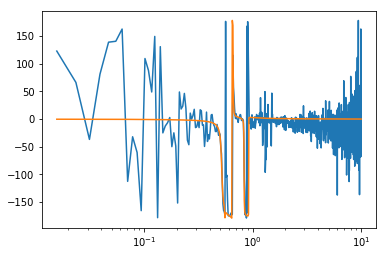

In [289]:
plt.loglog(f, abs(L2P))
# plt.loglog(f, abs(L2P_model.horner(2*np.pi*1j*f)[0][0]))
plt.loglog(f, abs(L2P_fit.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(L2P)*180/np.pi))
# plt.semilogx(f, np.angle(L2P_model.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
plt.semilogx(f, np.angle(L2P_fit.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
# plt.xlim(0.1,10)

In [225]:
res.x

array([-2.69734386e-17,  5.19027582e-01,  6.67085429e-01,  8.32750693e-01,
        1.54758465e-07,  9.14826476e-01,  1.21981457e+02,  1.08409579e+01,
        1.14235549e+03,  4.49991078e+02,  9.69495638e+02])

In [269]:
args=res.x
k=args[0]
p1=args[1]
p2=args[2]
p3=args[3]
z4=args[4]
z5=args[5]
q1=args[6]
q2=args[7]
q3=args[8]
q4=args[9]
q5=args[10]
L2P_fit = k*sso(p1,q1)/sso(z4,q4)*sso(p2,q2)*sso(p3,q3)/sso(z5,q5)

In [291]:
L2P_fit


        -1.856e-07 s^6 - 3.341e-09 s^5 - 8.389e-06 s^4 - 1.031e-07 s^3 - 7.416e-05 s^2 - 6.829e-09 s - 7.488e-12
------------------------------------------------------------------------------------------------------------------------
4.035e-05 s^8 + 8.07e-06 s^7 + 0.002714 s^6 + 0.000433 s^5 + 0.06495 s^4 + 0.007373 s^3 + 0.6607 s^2 + 0.04003 s + 2.428

In [290]:
L2P_fit.pole()

array([-0.01369174+5.22915836j, -0.01369174-5.22915836j,
       -0.00936872+4.15857696j, -0.00936872-4.15857696j,
       -0.00552341+3.46547345j, -0.00552341-3.46547345j,
       -0.07142578+3.25463457j, -0.07142578-3.25463457j])

In [223]:
L2P_fit.zero()

array([-2.96444050e-03+5.74802351e+00j, -2.96444050e-03-5.74802351e+00j,
       -1.08043933e-09+9.72375513e-07j, -1.08043933e-09-9.72375513e-07j])

In [185]:
L2P_fit.damp()

(array([5.2488262, 5.2488262, 4.2128287, 4.2128287, 3.2339319, 3.2339319]),
 array([ 0.00374147,  0.00374147,  0.01305851,  0.01305851, -0.01453781,
        -0.01453781]),
 array([-0.01963834+5.24878946j, -0.01963834-5.24878946j,
        -0.05501326+4.21246949j, -0.05501326-4.21246949j,
         0.04701428+3.23359014j,  0.04701428-3.23359014j]))

In [181]:
items_p2p = dtt2hdf.read_diaggui('./data/SRM_TMP_200722.xml')
f=items_p2p.results.CSD['K1:VIS-SRM_TM_TEST_P_EXC'].FHz
mask = 0.01<f
mask2 = f<10
mask=mask*mask2
# mask2 = f<10
f=f[mask]
P2P_CSD = items_p2p.results.CSD['K1:VIS-SRM_TM_TEST_P_EXC'].CSD[10]
P_exc_PSD = items_p2p.results.PSD['K1:VIS-SRM_TM_TEST_P_EXC'].PSD[0]
P2P = P2P_CSD/P_exc_PSD**2
P2P=P2P[mask]

In [344]:
P2P_model=0.1*sso(0.5,1000)/sso(0.51,1000)*sso(0.8,1000)

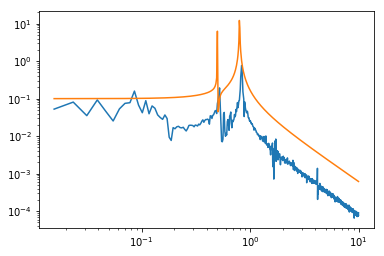

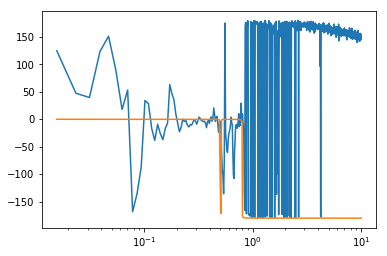

In [345]:
plt.loglog(f, abs(P2P))
plt.loglog(f, abs(P2P_model.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(P2P)*180/np.pi))
plt.semilogx(f, unwrap(np.angle(P2P_model.horner(2*np.pi*1j*f)[0][0]))*180/np.pi)
# plt.xlim(0.1,10)

In [346]:
weight = np.ones_like(f)
for i in range(len(weight)):
    if f[i]<0.1 or f[i]>2:
        weight[i]=0

x0=list(P2P_model.num[0][0])+list(P2P_model.den[0][0])
res = minimize(cost, args=(P2P_model, f, P2P, weight), x0 = x0, method='Nelder-Mead', 
               options= {'disp':True, 'maxiter': 100000, 'maxfev': 100000})

Optimization terminated successfully.
         Current function value: 82.630275
         Iterations: 3236
         Function evaluations: 4774


In [347]:
args=res.x
fit_num = args[0:len(P2P_model.num[0][0])]
fit_den = args[len(P2P_model.num[0][0]):len(args)]
P2P_fit = tf(fit_num, fit_den)

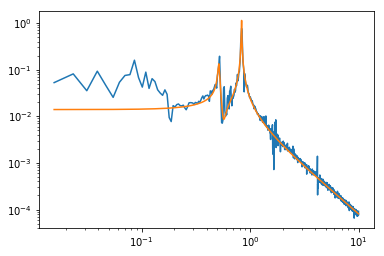

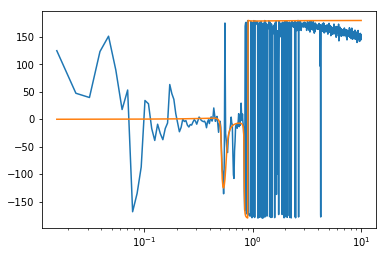

In [348]:
plt.loglog(f, abs(P2P))
# plt.loglog(f, abs(P2P_model.horner(2*np.pi*1j*f)[0][0]))
plt.loglog(f, abs(P2P_fit.horner(2*np.pi*1j*f)[0][0]))
# plt.xlim(0.1,10)
plt.figure()
plt.semilogx(f, (np.angle(P2P)*180/np.pi))
# plt.semilogx(f, np.angle(P2P_model.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
plt.semilogx(f, np.angle(P2P_fit.horner(2*np.pi*1j*f)[0][0])*180/np.pi)
# plt.xlim(0.1,10)

In [335]:
P2P_fit.pole()

array([-0.02410802+5.24377208j, -0.02410802-5.24377208j,
       -0.08942828+3.24150535j, -0.08942828-3.24150535j,
        0.09948943+3.24016758j,  0.09948943-3.24016758j])

In [330]:
P2P_fit


                44.34 s^4 + 0.7516 s^3 + 1039 s^2 - 2.268 s + 6086
---------------------------------------------------------------------------------
142.7 s^6 + 4.01 s^5 + 6921 s^4 + 35.09 s^3 + 9.815e+04 s^2 - 74.75 s + 4.337e+05

In [349]:
L2PonP2P=L2P_fit/P2P_fit
L2PonP2P.minreal().num

[[array([-1.45147520e-02, -2.32629280e-03, -1.20772295e+00, -1.57949022e-01,
         -3.49293352e+01, -3.31456809e+00, -4.10043417e+02, -2.09758571e+01,
         -1.67619014e+03, -1.54348280e-01, -1.69229693e-04])]]

In [300]:
L2PonP2P.minreal().zero()

array([-1.01165007e-03+5.75783126e+00j, -1.01165007e-03-5.75783126e+00j,
       -2.34718513e-02+5.24162069e+00j, -2.34718513e-02-5.24162069e+00j,
       -7.94458396e-03+3.47197431e+00j, -7.94458396e-03-3.47197431e+00j,
       -1.47926617e-03+3.30192786e+00j, -1.47926617e-03-3.30192786e+00j,
       -4.60408230e-05+3.14390327e-04j, -4.60408230e-05-3.14390327e-04j])

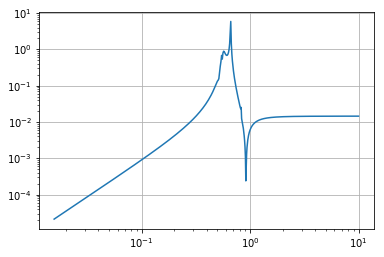

In [350]:
plt.loglog(f,abs(L2PonP2P.minreal().horner(2*np.pi*1j*f)[0][0]))
plt.grid()